# Cálculo de métricas de desempeño de un modelo YOLOv4

* **Autor:** Julián Zuloaga
* **Asignatura:** Memoria de Título
---
**Descripción:** Este notebook tiene como objetivo la generación de métricas de desempeño estándar para la evaluación de un modelo de YOLOv4 entrenado para el reconocimiento de expresiones faciales en multitudes.

Las métricas obtenidas en este programa son:
* Precision
* Recall
* Curva Precision Recall
* mean Average Precision (mAP), Macro.
* Matriz de Confusion
* Curva ROC
* AUC

Se utiliza la biblioteca Scikit para la obtención de las métricas anteriormente mencionadas, para ello, se modifica el formato de los resultados de inferencia del modelo de YOLOv4 sobre el conjunto de testeo para adaptarlos al formato admitido por Scikit. Para considerar a aquellos casos en que el modelo detecta un falso positivo en el fondo, o cuando omite un rostro considerandolo como parte del fondo, se añade una clase *Background*. Notar que el dataset de testeo para evaluación está constituido por Custom Mosaics balanceados. (generado con *Balanceo_de_conjuntos_de_evaluacion_MDT.ipynb*)


# Paso 1: Importar recursos básicos

In [ ]:
# Se importan las librerías necesarias
from tabulate import tabulate # librería para imprimir tablas y que queden bonitas
import cv2 # Se importa OpenCV
from google.colab.patches import cv2_imshow # Se importa visualizador de imágenes de OpenCV para Google Colab
from collections import namedtuple # Se utiliza para definir rectángulos
import numpy as np # para manejo de arreglos de Numpy
import glob # para manejo de archivos y directorios
import math # para manejo de funciones matemáticas
from matplotlib.pyplot import figure # para modificar parámetros de los gráficos
import matplotlib.pyplot as plt # para graficar curvas
import pandas as pd # para manejo de dataframes
import seaborn as sns
from itertools import cycle # para graficar curvas con un conjunto definido de colores
from sklearn.metrics import confusion_matrix # para generar matriz de confusión
from sklearn.metrics import average_precision_score # para calcular mAP
from sklearn.metrics import roc_curve # para graficar curva ROC
from sklearn.metrics import auc #para calcular área bajo la curva ROC
from sklearn.metrics import precision_recall_curve # para calcular la curva P-R

In [ ]:
# Se clona el repositorio de Alexey Bochkovskiy con YOLOv4 y el framework Darknet
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# Se modifica el archivo makefile para habilitar el uso de GPU y OPENCV
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
# Se verifica versión de CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# Se decarga archivo personalizado de detector.c para generación de métricas para curva Precision-Recall.
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hHRCnifbhAVt-6XlKKSaWN6sTEF_1fhs' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hHRCnifbhAVt-6XlKKSaWN6sTEF_1fhs" -O /content/darknet/src/detector.c && rm -rf /tmp/cookies.txt

In [ ]:
# make darknet
!make

# Paso 2: Importar el modelo de YOLOv4 entrenado para FER en multitudes

In [ ]:
# Se descarga pesos de modelo YOLOv4_mosaic_v8
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PTrlol9-OGPe3lM7KJwcc-XA8seb3TtI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1PTrlol9-OGPe3lM7KJwcc-XA8seb3TtI" -O /content/darknet/yolov4-obj_last.weights && rm -rf /tmp/cookies.txt
# junto con sus archivos de configuración...
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P643oZOIqsR6ETwviBSfciY5H7G1VJzU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1P643oZOIqsR6ETwviBSfciY5H7G1VJzU" -O /content/darknet/cfg/yolov4-obj.cfg && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1w3k0on_S-V75DF5cSz7L2-rXaOI6jG7D' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1w3k0on_S-V75DF5cSz7L2-rXaOI6jG7D" -O /content/darknet/data/obj.names && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-v8GQMFtzc74VSqCiTEJb2yREd3VxqPz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-v8GQMFtzc74VSqCiTEJb2yREd3VxqPz" -O /content/darknet/data/obj.data && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xxYdRcOdeNvmY-TS12e5xhoVOqQa06B4' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xxYdRcOdeNvmY-TS12e5xhoVOqQa06B4" -O /content/darknet/generate_train.py && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1f_-qrgYNpbSTM-S0mkemWOapAcOLV-L9' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1f_-qrgYNpbSTM-S0mkemWOapAcOLV-L9" -O /content/darknet/generate_test.py && rm -rf /tmp/cookies.txt
# y datasets...
# train: (no es necesario para realizar inferencias, por lo que se omite en este notebook)
# testeo mosaico balanceado v1:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-4xLzCmvAnrneqsc3YfTnenZVt26xFFi' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-4xLzCmvAnrneqsc3YfTnenZVt26xFFi" -O /content/darknet/test.zip && rm -rf /tmp/cookies.txt 


In [ ]:
# Se descomprime el set de validación o testeo
!unzip ./test.zip -d data/test #test.zip

In [ ]:
# Se ejecutan los archivos recien subidos
!python generate_test.py

In [ ]:
# Se verifica que se haya generado el archivo test.txt
!ls data/

In [ ]:
# Se modifica el archivo de configuración .cfg para correr pruebas con mayor precision
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
!sed -i 's/width=608/width=768/' yolov4-obj.cfg
!sed -i 's/height=608/height=768/' yolov4-obj.cfg
%cd ..

In [ ]:
# Se importan funciones del framework Darknet para realizar inferencias programáticamente por medio de Python
# Leear archivo darknet.py para acceder a toda la documentación disponible.
from darknet import *
# se carga la red neuronal de nuestro modelo
network, class_names, class_colors = load_network("cfg/yolov4-obj.cfg", "data/obj.data", "yolov4-obj_last.weights")

#En este caso, cargamos los archivos de nuestro modelo personalizado
width = network_width(network)
height = network_height(network)

# esta función nos ayudará a realiar inferencias sobre imágenes más facilmente
def darknet_helper(img, width, height, myclass_thresh):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # se obtiene relación de aspecto de la imagen de entrada para obtener parámetros de bbox
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # se ejecuta las inferencias utilizando el modelo cargado
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image, thresh=myclass_thresh)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [ ]:
# Se define titulo de columnas de la matriz de confusión (Es decir, las clases)
headers = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger','Contempt','Background']

In [ ]:
# se definen los colores de cada clase para los bounding boxes
class_colors =  {'Neutral':  (250, 45, 0), #azul
                 'Happy':    (0, 45, 250), #rojo
                 'Sad':      (255, 249, 67), #amarillo
                 'Surprise': (67, 252, 255), #celeste
                 'Fear':     (132, 67, 255), #morado
                 'Disgust':  (67, 255, 87), #verde
                 'Anger':    (255, 67, 132), #rosado
                 'Contempt': (250, 155, 34), #naranjo
                 'Background': (0, 0, 0) # negro
                 }

In [ ]:
# Se define función auxiliar para detectar colisiones entre bounding boxes
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')
def area(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

In [ ]:
# Se define función auxiliar para convertir color de truple a formato hex
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

# Paso 3: Generación de resultados de inferencia sobre set de evaluación




Para la obtención de las métricas de desempeño, primero es necesario contar con un conjunto de resultados de parte del modelo sobre un conjunto de evaluación. Dichos resultados serán trabajados como dos listas de Python, con los nombres y_pred (resultado de inferencia generado por el modelo) e y_test (ground thruth del set de testeo). Notar sin embargo, que los resultados de inferencia del modelo son tratado de manera distinta, dependiendo de la métrica siendo calculada, pero el procedimiento es similar en todos los casos.

In [ ]:
# se define umbral de confianza para predicción de clase
class_thresh = 0.25

# Se crea lista con registro de intersecciones entre rectángulos
intersect_reg = list()
detections_reg = list() ## esta lista estará en el formato que pide roc_curve() de Scikit
conf_list = list() # lista con confianza de las detecciones en la imagen siendo procesada
# Se crea lista con los rectángulos de inferencia de una imagen
rectangulos_inf = list()
# Se crea lista con rectángulos ground truth
rectangulos_tru = list()
# Se crea lista con las etiquetas de clase para cada rectángulo de inferencia
label_inf = list()
# Se crea lista con las etiquetas de clase para cada rectángulo ground truth
label_tru = list()
# Se crea lista con los nombres de las imágenes en el set de validación
img_val_list = list()

# Contadores
process_counter = 0
img_counter = 0
rectangulos_tru_acum = 0

# Se genera lista con las imágenes del set de validación (o testeo)
img_val_list = [x for x in glob.glob("/content/darknet/data/test/*.jpg")]

# Se itera la lista de imágenes de validación (o testo)
for img_addrs in img_val_list:
  img_counter += 1 # se incrementa contador de imágenes procesadas
  # Se abre imagen con opencv, necesario para realizar inferencia sobre ella
  image = cv2.imread(img_addrs)
  ############## 1) Se obtiene el ground truth de la imagen de validación a partir de su archivo de texto asociado
  anotaciones = open(f'{img_addrs[:-4]}.txt')
  parameters = anotaciones.readlines() # Se lee la línea con los parámetros del rostro
  # se itera línea por línea de parámetros
  for line in parameters:
    separated_params = line.split(" ")
    x, y, w, h = (float(separated_params[1]), float(separated_params[2]), float(separated_params[3]), float(separated_params[4]))
    x, y, w, h = int(x * 1024), int(y * 768), int(w * 1024), int(h * 768)
    left, top, right, bottom = int(x-(w/2)), int(y-(h/2)), int(x+(w/2)), int(y+(h/2))
    xmin = left
    ymin = top
    xmax = right
    ymax = bottom
    # Se genera rectángulo con coordenadas de ground truth
    r1 = Rectangle(xmin,ymin,xmax,ymax) # xmin, ymin, xmax, ymax
    # Se agrega a lista de rectángulos ground truth
    rectangulos_tru.append(r1)
    # Se agrega etiqueta de clase del rectángulo a la lista de etiquetas ground truth
    label = headers[int(separated_params[0])]
    label_tru.append(label)
    # Se asigna confidence = 1 para el ground truth
    confidence = 1
  ############## 2) Se realiza inferencia sobre imágen de validación
  detections, width_ratio, height_ratio = darknet_helper(image, width, height, class_thresh)
  # Se itera sobre los resultados (clase, confianza y bbox) de la detección:
  # Detections retorna (left_x, top_y, width, height), así que se calculan los parámetros para el rectángulo:
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    xmin = left
    ymin = top
    xmax = right
    ymax = bottom
    # Se genera rectángulo
    r1 = Rectangle(left,top,right,bottom) # xmin, ymin, xmax, ymax
    # se agrega a la lista de rectángulos de inferencia de esta imagen
    rectangulos_inf.append(r1)
    # se agrega etiqueta de clase a lista de etiquetas de inferencia
    label_inf.append(label)
    # se agrega confianza de la inferencia a la lista
    conf_list.append(confidence)
  ############# 3) Se comparan los resultados de inferencia con el ground truth del mosaico
  # se itera ambas listas de rectángulos ground truth
  for i in range(0, len(rectangulos_tru)):
    do_tru_intersect = False # se inicializa variable para verificar intersección entre rectángulos
    for j in range(0, len(rectangulos_inf)): # se itera la lista de rectángulos inferidos
      # Se calcula el area de intersección entre ambos rectángulos
      intersec = area(rectangulos_inf[j],rectangulos_tru[i])
      if intersec != 0: # si se detectó intersección entre áreas, se hace lo siguiente
        do_tru_intersect = True # se cambia variable de verificación de intersección a verdadero
        # Se calcula la unión del bbox ground truth y el bbox inferido
        union_bbox = area(rectangulos_inf[j],rectangulos_inf[j]) + area(rectangulos_tru[i],rectangulos_tru[i]) - intersec
        # Se calcula la intesercción sobre la unión (IOU)
        iou_bbox = intersec/union_bbox
        # Se guarda intersecciones en el registro
        intersect_reg.append((rectangulos_inf[j], rectangulos_tru[i], iou_bbox, label_tru[i], label_inf[j]))
        detections_reg.append((label_tru[i], label_inf[j], conf_list[j]))
    # si no se detectó intersección, se hace lo siguiente
    if do_tru_intersect == False:
      # se agrega rectángulo al registro, como si estuviera intersectándo con el fondo (background)
      intersect_reg.append((Rectangle(0,0,1,1), rectangulos_tru[i], 1, label_tru[i], "Background"))
      detections_reg.append((label_tru[i], "Background", 1))

  # Se itera lista de rectángulos inferidos
  for i in range(0, len(rectangulos_inf)):
    do_inf_intersect = False
    # se itera lista de re´ctángulos ground truth
    for j in range(0, len(rectangulos_tru)):
      # se calcula área de intersección entre rectángulos
      intersec = area(rectangulos_inf[i],rectangulos_tru[j])
      if intersec != 0:
        do_inf_intersect = True
    # se verifica intersección
    if do_inf_intersect == False:
      # se agrega rectángulo al registro
      intersect_reg.append((rectangulos_inf[i], Rectangle(0,0,1,1), 1, "Background", label_inf[i]))
      detections_reg.append(("Background", label_inf[i], conf_list[i]))

  # Se limpian las listas para que puedan ser usadas en el procesamiento de la siguiente imagen
  rectangulos_tru_acum = rectangulos_tru_acum + len(rectangulos_tru)
  rectangulos_inf.clear()
  rectangulos_tru.clear()
  label_inf.clear()
  label_tru.clear()
  conf_list.clear()
  anotaciones.close()

# Paso 4: Matriz de Confusión

In [ ]:
# se generan listas con el ground truth del set de testeo y con las predicciones del modelo
y_test = [x[3] for x in intersect_reg]
y_pred = [x[4] for x in intersect_reg]

In [ ]:
# Se crea una matriz de confusión que compara y_test e y_pred
cm = confusion_matrix(y_test, y_pred, labels=headers, normalize='pred')
# Se crea un dataframe para facilitar el graficado de la matriz de confusión
myindex = [x for x in headers]
mycolumns = [x for x in headers]
cm_df = pd.DataFrame(cm,
                     index = myindex, 
                     columns = mycolumns)
# Se grafica la matriz de confusión
plt.figure(figsize=(12,11))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title(f'Confusion Matrix (conf_thresh {class_thresh*100}%)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Paso 5: Curva ROC

In [ ]:
# Se calcula el número de clases sin el background
n_classes = len(headers)
# Se inicializan arreglos de numpy para cargar los resultados obtenidos antes
sep_y_test = np.zeros(shape = (len(detections_reg),n_classes), dtype = 'float')
sep_y_pred = np.zeros(shape = (len(detections_reg),n_classes), dtype = 'float')
# Se escriben resultados de inferencia y ground truth (confidence scores) a formato de la función roc_curve()
for i in range(len(detections_reg)):
  class_index_inf = headers.index(detections_reg[i][1])
  class_index_tru = headers.index(detections_reg[i][0])
  sep_y_pred[i, class_index_inf] = float(detections_reg[i][2])/100
  sep_y_test[i, class_index_tru] = 1
# Se calcula la curva ROC y su área para cada clase
fpr = dict() # se inicializa diccionario para el false positive rate
tpr = dict() # se inicializa diccionario para el true positive rate
roc_auc = dict() # se inicializa diccionario para el área bajo la curva ROC
# se calcula el FPR, TPR y AUC de manera iterativa para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], out_thresh1 = roc_curve(y_true = sep_y_test[:, i], y_score = sep_y_pred[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])
# Se calcula la curva ROC Micro average y su AUC
fpr["micro"], tpr["micro"], out_thresh2 = roc_curve(sep_y_test.ravel(), sep_y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Se grafica la curva ROC para todas las clases del modelo
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Se interpolan todas las curvas ROC
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Se calcula el Macro-Average y su AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Se calculan todas las curvas ROC
plt.figure(figsize=(8,8), dpi=120)
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw=2
colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "blue", "green", "brown", "purple", "yellow"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label = f"ROC curve of class {headers[i]} (area = {roc_auc[i]:0.2f})"
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (conf_thresh {class_thresh*100}%)")
plt.legend(loc="lower right")
plt.show()

# Paso 6: Curva Precision-Recall

Para obtener la curva Precision-Recall, se ejecuta medición de precisión usando la instrucción de Darknet y se reunen los Precision y Recall para cada categoría obtenidos.

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.01

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.10

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.20

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.30

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.40

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.50

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.60

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.70

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.80

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.90

In [ ]:
# Medición de precisión sobre test.zip (default)
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -thresh 0.99

Si se grafican los resultados obtenidos anteriormente, se obtiene la siguiente curva Precision Recall para el modelo, considerando thresh_conf entre {0.01 y 0.99}.

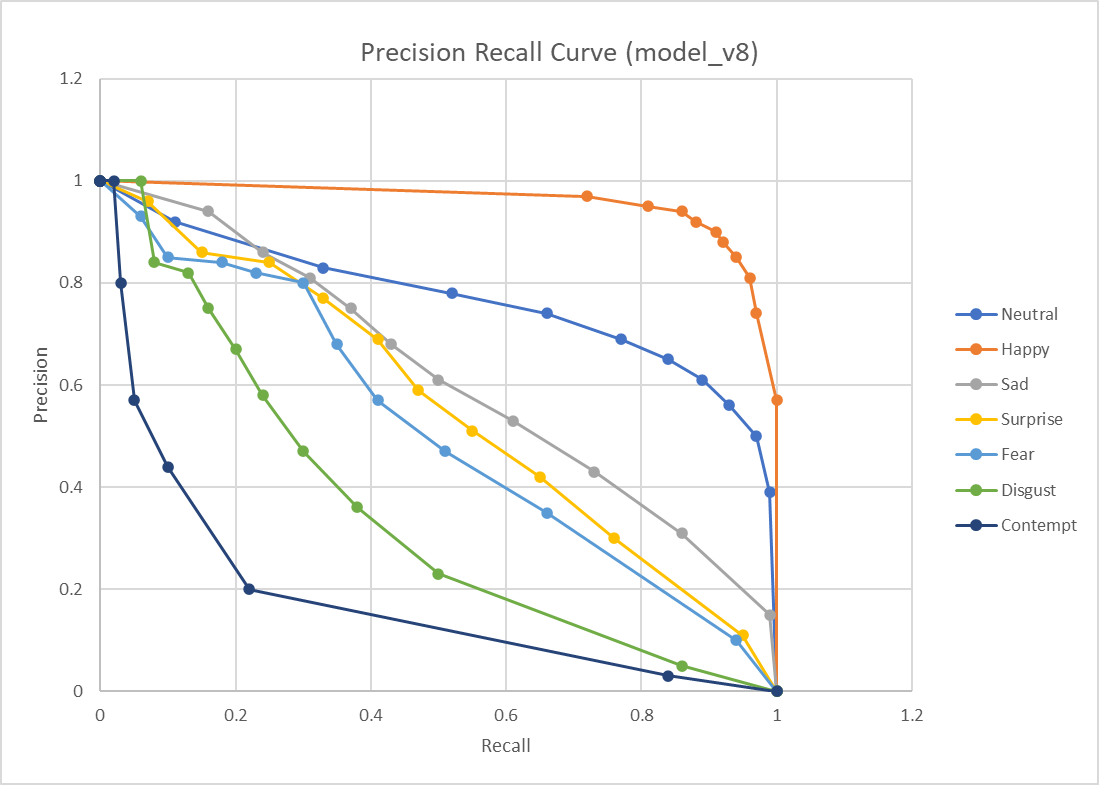

# Paso 7: Cálculo de mAP

Una manera de resumir las curvas Precision Recall obtenidas en el paso 6 es por medio del cálculo del área bajo cada curva. Si se promedian estas áreas, se obtiene el parámetro mean Average Precision (mAP).

In [ ]:
# En base a lo obtenido en el paso 6, se tiene:
ap_neutral = 76.94
ap_happy = 96.4
ap_sad = 62.14
ap_surprise = 55.85
ap_fear = 51.13 
ap_disgust = 34.48
ap_anger = 60.57
ap_contempt = 15.80

mAP = ap_neutral + ap_happy + ap_sad + ap_surprise + ap_fear + ap_disgust + ap_anger + ap_contempt
mAP = mAP/8

print(f"mAP del modelo: {mAP}")